In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configura√ß√µes para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print("Setup inicial e importa√ß√µes conclu√≠dos.")

Setup inicial e importa√ß√µes conclu√≠dos.


In [ ]:
# --- Fun√ß√µes do Deep Learning ---
def load_and_preprocess_data():
    digits = load_digits()
    X_original = digits.data # Dados originais antes da normaliza√ß√£o
    X_normalized = digits.data / 16.0 # Dados normalizados
    y = digits.target
    x_treino, x_teste, y_treino, y_teste = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    # Mostrar uma amostra dos dados antes e depois da normaliza√ß√£o
    sample_indices = np.random.choice(len(X_original), 5, replace=False)
    sample_original = X_original[sample_indices]
    sample_normalized = X_normalized[sample_indices]

    comparison_data = []
    for i in range(len(sample_indices)):
        comparison_data.append({
            '√çndice Original': sample_indices[i],
            'Dados Originais (Amostra)': sample_original[i].tolist(),
            'Dados Normalizados (Amostra)': sample_normalized[i].tolist()
        })

    comparison_df = pd.DataFrame(comparison_data)
    print("\nAmostra dos Dados Antes e Depois da Normaliza√ß√£o:")
    display(comparison_df)


    return x_treino, x_teste, y_treino, y_teste, digits.images

def build_model_for_ag_fitness(input_shape, hidden_layer_1_weights=None, hidden_layer_1_biases=None):
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),
        keras.layers.Dense(128, activation='relu', name='ag_hidden_layer'), # Nomeamos para f√°cil acesso
        keras.layers.Dense(64, activation='relu'), # Segunda Camada Oculta
        keras.layers.Dense(10, activation='softmax') # Camada de sa√≠da
    ])

    if hidden_layer_1_weights is not None and hidden_layer_1_biases is not None:
        # Define os pesos da camada que o AG est√° otimizando
        model.get_layer('ag_hidden_layer').set_weights([hidden_layer_1_weights, hidden_layer_1_biases])
        # Congela esta camada para que o otimizador Keras n√£o a altere
        model.get_layer('ag_hidden_layer').trainable = False

    # Compila o modelo. O otimizador s√≥ afetar√° as camadas trein√°veis.
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['sparse_categorical_accuracy']
    )
    return model

# --- Fun√ß√µes Auxiliares para Manipula√ß√£o de Pesos ---
def flatten_weights(weights_list):
    flattened = []
    for arr in weights_list:
        flattened.extend(arr.flatten())
    return np.array(flattened)

def unflatten_weights(flat_weights, layer_shapes):
    reshaped_weights = []
    current_index = 0
    for w_shape, b_shape in layer_shapes:
        # Pesos (W)
        size_w = np.prod(w_shape)
        w = flat_weights[current_index : current_index + size_w].reshape(w_shape)
        reshaped_weights.append(w)
        current_index += size_w

        # Vieses (b)
        size_b = np.prod(b_shape)
        b = flat_weights[current_index : current_index + size_b].reshape(b_shape)
        reshaped_weights.append(b)
        current_index += size_b
    return reshaped_weights

print("Fun√ß√µes base e auxiliares definidas.")

Fun√ß√µes base e auxiliares definidas.


In [14]:
# Carregar e preprocessar os dados para definir as vari√°veis
x_treino, x_teste, y_treino, y_teste, X = load_and_preprocess_data()

print("\n--- Formas dos Dados ---")
print(f"Forma de X (dados originais): {X.shape}")
print(f"Forma de x_treino: {x_treino.shape}")
print(f"Forma de y_treino: {y_treino.shape}")
print(f"Forma de x_teste: {x_teste.shape}")
print(f"Forma de y_teste: {y_teste.shape}")


Amostra dos Dados Antes e Depois da Normaliza√ß√£o:


√çndice Original                          Dados Originais (Amostra)  \
0             1245  [0.0, 0.0, 0.0, 7.0, 12.0, 0.0, 0.0, 0.0, 0.0,...   
1              220  [0.0, 0.0, 11.0, 16.0, 8.0, 0.0, 0.0, 0.0, 0.0...   
2             1518  [0.0, 0.0, 8.0, 15.0, 12.0, 4.0, 0.0, 0.0, 0.0...   
3              438  [0.0, 0.0, 2.0, 12.0, 12.0, 12.0, 9.0, 2.0, 0....   
4             1270  [0.0, 2.0, 13.0, 16.0, 10.0, 0.0, 0.0, 0.0, 0....   

                        Dados Normalizados (Amostra)  
0  [0.0, 0.0, 0.0, 0.4375, 0.75, 0.0, 0.0, 0.0, 0...  
1  [0.0, 0.0, 0.6875, 1.0, 0.5, 0.0, 0.0, 0.0, 0....  
2  [0.0, 0.0, 0.5, 0.9375, 0.75, 0.25, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.125, 0.75, 0.75, 0.75, 0.5625, 0....  
4  [0.0, 0.125, 0.8125, 1.0, 0.625, 0.0, 0.0, 0.0...


--- Formas dos Dados ---
Forma de X (dados originais): (1797, 8, 8)
Forma de x_treino: (1437, 64)
Forma de y_treino: (1437,)
Forma de x_teste: (360, 64)
Forma de y_teste: (360,)


In [15]:
# --- Carregar e Preparar Dados ---
x_treino, x_teste, y_treino, y_teste, _ = load_and_preprocess_data()

# Para a fun√ß√£o de aptid√£o, usaremos uma parte do treino para valida√ß√£o interna do AG
# E o conjunto de teste final para a avalia√ß√£o do modelo com os melhores pesos do AG.
x_ag_val, x_ag_train, y_ag_val, y_ag_train = train_test_split(x_treino, y_treino, test_size=0.7, random_state=42)

#Determina√ß√£o do Tamanho do Indiv√≠duo no Algoritmo Gen√©tico
temp_model = build_model_for_ag_fitness(input_shape=[64])
hidden_layer_1_weights_keras_format = temp_model.get_layer('ag_hidden_layer').get_weights()
hidden_layer_shapes = [(hidden_layer_1_weights_keras_format[0].shape, hidden_layer_1_weights_keras_format[1].shape)]
individual_size = len(flatten_weights(hidden_layer_1_weights_keras_format))

print(f"\n---Determina√ß√£o do Tamanho do Indiv√≠duo no Algoritmo Gen√©tico---")
print(f"Tamanho de um indiv√≠duo AG (vetor de pesos achatado): {individual_size}")

print("\n--- Informa√ß√µes Sobre o Algoritmo Gen√©tico ---")

print(f"N√∫mero de neur√¥nios de entrada: {x_treino.shape[1]}")
print(f"N√∫mero de neur√¥nios na camada oculta: {hidden_layer_1_weights_keras_format[0].shape[1]}")
print(f"N√∫mero de neur√¥nios na camada de sa√≠da: {hidden_layer_1_weights_keras_format[0].shape[0]}")
print(f"Tamanho das camadas ocultas: {hidden_layer_shapes}")
print(f"Tamanho do vetor de pesos achatado: {len(flatten_weights(hidden_layer_1_weights_keras_format))}")
print(f"Tamanho do conjunto de valida√ß√£o do AG: {len(x_ag_val)}")
print(f"Tamanho do conjunto de treino do AG: {len(x_ag_train)}")
print(f"Tamanho do conjunto de teste final: {len(x_teste)}")



print("\n--- Formas dos Subconjuntos para Avalia√ß√£o do AG ---")

print("\nResumo da arquitetura da MLP para inspe√ß√£o:")
temp_model.summary()


Amostra dos Dados Antes e Depois da Normaliza√ß√£o:


√çndice Original                          Dados Originais (Amostra)  \
0             1407  [0.0, 0.0, 14.0, 16.0, 16.0, 16.0, 2.0, 0.0, 0...   
1              411  [0.0, 0.0, 6.0, 8.0, 11.0, 14.0, 14.0, 0.0, 0....   
2              802  [0.0, 0.0, 0.0, 11.0, 13.0, 5.0, 0.0, 0.0, 0.0...   
3              550  [0.0, 0.0, 2.0, 13.0, 16.0, 8.0, 0.0, 0.0, 0.0...   
4             1546  [0.0, 0.0, 0.0, 14.0, 10.0, 0.0, 0.0, 0.0, 0.0...   

                        Dados Normalizados (Amostra)  
0  [0.0, 0.0, 0.875, 1.0, 1.0, 1.0, 0.125, 0.0, 0...  
1  [0.0, 0.0, 0.375, 0.5, 0.6875, 0.875, 0.875, 0...  
2  [0.0, 0.0, 0.0, 0.6875, 0.8125, 0.3125, 0.0, 0...  
3  [0.0, 0.0, 0.125, 0.8125, 1.0, 0.5, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.875, 0.625, 0.0, 0.0, 0.0, 0...


---Determina√ß√£o do Tamanho do Indiv√≠duo no Algoritmo Gen√©tico---
Tamanho de um indiv√≠duo AG (vetor de pesos achatado): 8320

--- Informa√ß√µes Sobre o Algoritmo Gen√©tico ---
N√∫mero de neur√¥nios de entrada: 64
N√∫mero de neur√¥nios na camada oculta: 128
N√∫mero de neur√¥nios na camada de sa√≠da: 64
Tamanho das camadas ocultas: [((64, 128), (128,))]
Tamanho do vetor de pesos achatado: 8320
Tamanho do conjunto de valida√ß√£o do AG: 431
Tamanho do conjunto de treino do AG: 1006
Tamanho do conjunto de teste final: 360

--- Formas dos Subconjuntos para Avalia√ß√£o do AG ---

Resumo da arquitetura da MLP para inspe√ß√£o:


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ ag_hidden_layer (Dense)              ‚îÇ (None, 128)                 ‚îÇ           8,320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                      ‚îÇ (None, 64)                  ‚îÇ           8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (None, 10)                  ‚îÇ             650 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 17,226 (67.29 KB)

 Trainable params: 17,226 (67.29 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# --- Par√¢metros de Configura√ß√£o do Algoritmo Gen√©tico ---
POPULATION_SIZE = 50       # N√∫mero de indiv√≠duos na popula√ß√£o
NUM_GENERATIONS = 30       # N√∫mero de gera√ß√µes a serem executadas
MUTATION_RATE = 0.05       # Probabilidade de um peso sofrer muta√ß√£o
CROSSOVER_PROBABILITY = 0.8 # Probabilidade de dois pais cruzarem
NUM_PARENTS_TO_SELECT = POPULATION_SIZE
ELITE_COUNT = 2            # Quantos dos melhores indiv√≠duos passam diretamente para a pr√≥xima gera√ß√£o (elitismo)

print("\nPar√¢metros do Algoritmo Gen√©tico definidos:")
params_df = pd.DataFrame({
    'Par√¢metro': ['POPULATION_SIZE', 'NUM_GENERATIONS', 'MUTATION_RATE', 'CROSSOVER_PROBABILITY', 'ELITE_COUNT', 'Individual Size'],
    'Valor': [POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE, CROSSOVER_PROBABILITY, ELITE_COUNT, individual_size]
})
print(params_df.to_string(index=False))




Par√¢metros do Algoritmo Gen√©tico definidos:
            Par√¢metro   Valor
      POPULATION_SIZE   50.00
      NUM_GENERATIONS   30.00
        MUTATION_RATE    0.05
CROSSOVER_PROBABILITY    0.80
          ELITE_COUNT    2.00
      Individual Size 8320.00


In [17]:
# Divis√£o Adicional para Valida√ß√£o do Algoritmo Gen√©tico (AG):
from sklearn.model_selection import train_test_split

x_ag_val, x_ag_train, y_ag_val, y_ag_train = train_test_split(x_treino, y_treino, test_size=0.7, random_state=42)

print("\n--- Formas dos Subconjuntos para Avalia√ß√£o do AG ---")
print(f"Forma de x_ag_train: {x_ag_train.shape}")
print(f"Forma de y_ag_train: {y_ag_train.shape}")
print(f"Forma de x_ag_val: {x_ag_val.shape}")
print(f"Forma de y_ag_val: {y_ag_val.shape}")


--- Formas dos Subconjuntos para Avalia√ß√£o do AG ---
Forma de x_ag_train: (1006, 64)
Forma de y_ag_train: (1006,)
Forma de x_ag_val: (431, 64)
Forma de y_ag_val: (431,)


In [26]:
%pip install python-docx tabulate -q

from docx import Document
from docx.shared import Inches
from tabulate import tabulate
import os

# --- Criar os dados da tabela ---
dados = [
    ['X (dados originais)', str(X.shape), len(X),
     'Conjunto de dados completo de imagens de d√≠gitos, antes do achatamento e normaliza√ß√£o. Representa a entrada bruta.',
     'load_digits().images'],
    ['x_treino', str(x_treino.shape), len(x_treino),
     'Dados de entrada para o treinamento inicial da Rede Neural.',
     'train_test_split(X_normalized, y, test_size=0.2, random_state=42)'],
    ['y_treino', str(y_treino.shape), len(y_treino),
     'R√≥tulos correspondentes a x_treino.',
     'train_test_split(X_normalized, y, test_size=0.2, random_state=42)'],
    ['x_teste', str(x_teste.shape), len(x_teste),
     'Dados de entrada para a avalia√ß√£o final do modelo.',
     'train_test_split(X_normalized, y, test_size=0.2, random_state=42)'],
    ['y_teste', str(y_teste.shape), len(y_teste),
     'R√≥tulos correspondentes a x_teste.',
     'train_test_split(X_normalized, y, test_size=0.2, random_state=42)'],
    ['x_ag_train', str(x_ag_train.shape), len(x_ag_train),
     'Dados para o treinamento das camadas fixas no AG.',
     'train_test_split(x_treino, y_treino, test_size=0.3, random_state=42)'],
    ['y_ag_train', str(y_ag_train.shape), len(y_ag_train),
     'R√≥tulos correspondentes a x_ag_train.',
     'train_test_split(x_treino, y_treino, test_size=0.3, random_state=42)'],
    ['x_ag_val', str(x_ag_val.shape), len(x_ag_val),
     'Dados para valida√ß√£o da aptid√£o dos indiv√≠duos do AG.',
     'train_test_split(x_treino, y_treino, test_size=0.3, random_state=42)'],
    ['y_ag_val', str(y_ag_val.shape), len(y_ag_val),
     'R√≥tulos correspondentes a x_ag_val.',
     'train_test_split(x_treino, y_treino, test_size=0.3, random_state=42)'],
]

# --- Criar o documento Word com a tabela ---
doc = Document()
doc.add_heading('Resumo dos Conjuntos de Dados Utilizados', level=1)

table = doc.add_table(rows=1, cols=5)
table.style = 'Light Grid Accent 1'

# Cabe√ßalhos
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Conjunto de Dados'
hdr_cells[1].text = 'Forma (Dimens√µes)'
hdr_cells[2].text = 'N√∫mero de Amostras'
hdr_cells[3].text = 'Finalidade'
hdr_cells[4].text = 'Origem'

# Adicionar linhas
for row in dados:
    row_cells = table.add_row().cells
    for i, val in enumerate(row):
        row_cells[i].text = str(val)
    
# Salvar arquivo no diret√≥rio atual
file_path = r'C:\temp\tabela_dados.docx'
doc.save(file_path)

print("‚úÖ Documento Word gerado com sucesso!")
print(f"Arquivo salvo como: {os.path.abspath(file_path)}")

# Criar DataFrame para exibir a tabela no notebook
tabela = pd.DataFrame(dados, columns=['Conjunto de Dados', 'Forma (Dimens√µes)', 'N√∫mero de Amostras', 'Finalidade', 'Origem'])

# Exibir a tabela formatada
print("\n" + "="*100)
print("RESUMO DOS CONJUNTOS DE DADOS UTILIZADOS")
print("="*100)
print(tabulate(tabela, headers='keys', tablefmt='fancy_grid', showindex=False))



Note: you may need to restart the kernel to use updated packages.
‚úÖ Documento Word gerado com sucesso!
Arquivo salvo como: C:\temp\tabela_dados.docx

RESUMO DOS CONJUNTOS DE DADOS UTILIZADOS
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Conjunto de Dados   ‚îÇ Forma (Dim


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
!pip install pydot graphviz
!sudo apt-get install graphviz



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


‚úÖ Diagrama da arquitetura salvo como: C:\temp\arquitetura_rede.png


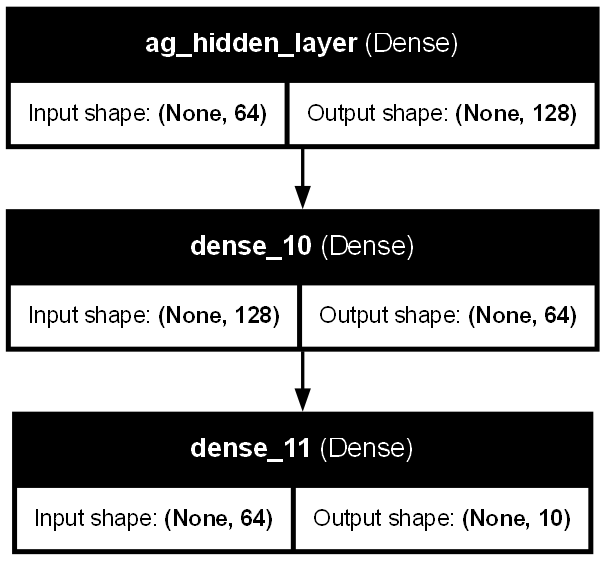

In [29]:
from tensorflow.keras.utils import plot_model
import os

# Certifique-se de ter o modelo compilado:
modelo_para_plotar = build_model_for_ag_fitness(input_shape=[64])

# Diret√≥rio de sa√≠da
saida_arquivo = r"C:\temp\arquitetura_rede.png"

try:
	# Gera o diagrama
	plot_model(modelo_para_plotar, to_file=saida_arquivo, show_shapes=True, show_layer_names=True, dpi=120)
	
	# Verifica se o arquivo foi criado
	if os.path.exists(saida_arquivo):
		print(f"‚úÖ Diagrama da arquitetura salvo como: {saida_arquivo}")
		
		# Mostra no notebook (se estiver usando Jupyter/Colab)
		from IPython.display import Image, display
		display(Image(filename=saida_arquivo))
	else:
		print("‚ùå Erro: Arquivo de diagrama n√£o foi criado.")
		
except Exception as e:
	print(f"‚ùå Erro ao gerar o diagrama: {e}")
	print("\nAlternativa: Exibindo resumo da arquitetura:")
	modelo_para_plotar.summary()


In [30]:
# --- Fun√ß√µes do Algoritmo Gen√©tico ---

### **Passo 1: Gerar Popula√ß√£o Inicial**
def generate_initial_population(pop_size, individual_size):
    population = [np.random.uniform(low=-1.0, high=1.0, size=individual_size) for _ in range(pop_size)]
    return population

### **Passo 2: Avaliar Aptid√£o (Fitness)**
def evaluate_fitness(individual, x_val, y_val, model_input_shape, hidden_layer_shapes_info):
    weights_w_b = unflatten_weights(individual, hidden_layer_shapes_info)
    hidden_weights = weights_w_b[0]
    hidden_biases = weights_w_b[1]

    model = build_model_for_ag_fitness(model_input_shape,
                                       hidden_layer_1_weights=hidden_weights,
                                       hidden_layer_1_biases=hidden_biases)

    # Pequeno treino para as outras camadas se adaptarem
    model.fit(x_ag_train, y_ag_train, epochs=5, verbose=0)

    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    return accuracy

### **Passo 3: Verificar Condi√ß√£o de T√©rmino** (Fun√ß√£o de monitoramento)
def check_termination_condition(generation, max_generations, best_fitness_current_gen):
    return generation >= max_generations

### **Passo 4: Sele√ß√£o**
def select_parents(population, fitness_scores, num_parents_to_select, elite_count=1):
    sorted_indices = np.argsort(fitness_scores)[::-1]
    sorted_population = [population[i] for i in sorted_indices]

    parents = sorted_population[:elite_count]

    for _ in range(num_parents_to_select - elite_count):
        # Sele√ß√£o por Torneio: seleciona um pequeno grupo e escolhe o melhor
        candidate_indices = np.random.choice(len(population), size=min(5, len(population)), replace=False)
        tournament_candidates = [population[i] for i in candidate_indices]
        tournament_fitness = [fitness_scores[i] for i in candidate_indices]
        best_in_tournament_idx = np.argmax(tournament_fitness)
        parents.append(tournament_candidates[best_in_tournament_idx])

    return parents

### **Passo 5: Cruzamento (Crossover)**
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

### **Passo 6: Muta√ß√£o**
def mutate(individual, mutation_rate, mutation_strength=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.uniform(-mutation_strength, mutation_strength)
            individual[i] = np.clip(individual[i], -1.0, 1.0) # Garante limites de pesos
    return individual

### **Passo 7: Substituir Popula√ß√£o Antiga**
def replace_population(old_population, parents, new_children, pop_size, elite_count=1):
    new_population_local = parents[:elite_count]

    current_children_idx = 0
    while len(new_population_local) < pop_size and current_children_idx < len(new_children):
        new_population_local.append(new_children[current_children_idx])
        current_children_idx += 1

    while len(new_population_local) < pop_size: # Preenche se ainda faltar (raro)
        new_population_local.append(np.random.uniform(low=-1.0, high=1.0, size=individual_size))

    return new_population_local

print("Fun√ß√µes do Algoritmo Gen√©tico definidas.")

Fun√ß√µes do Algoritmo Gen√©tico definidas.


In [31]:
print("\n--- Iniciando Otimiza√ß√£o com Algoritmo Gen√©tico ---")
print(f"Par√¢metros: Popula√ß√£o={POPULATION_SIZE}, Gera√ß√µes={NUM_GENERATIONS}, Muta√ß√£o={MUTATION_RATE}, Crossover={CROSSOVER_PROBABILITY}")


--- Iniciando Otimiza√ß√£o com Algoritmo Gen√©tico ---
Par√¢metros: Popula√ß√£o=50, Gera√ß√µes=30, Muta√ß√£o=0.05, Crossover=0.8


In [32]:
# --- Fun√ß√µes do Algoritmo Gen√©tico ---

### **Passo 1: Gerar Popula√ß√£o Inicial**
def generate_initial_population(pop_size, individual_size):
    population = [np.random.uniform(low=-1.0, high=1.0, size=individual_size) for _ in range(pop_size)]
    return population

### **Passo 2: Avaliar Aptid√£o (Fitness)**
def evaluate_fitness(individual, x_val, y_val, model_input_shape, hidden_layer_shapes_info):
    weights_w_b = unflatten_weights(individual, hidden_layer_shapes_info)
    hidden_weights = weights_w_b[0]
    hidden_biases = weights_w_b[1]

    model = build_model_for_ag_fitness(model_input_shape,
                                       hidden_layer_1_weights=hidden_weights,
                                       hidden_layer_1_biases=hidden_biases)

    # Pequeno treino para as outras camadas se adaptarem
    model.fit(x_ag_train, y_ag_train, epochs=5, verbose=0)

    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    return accuracy

### **Passo 3: Verificar Condi√ß√£o de T√©rmino** (Fun√ß√£o de monitoramento)
def check_termination_condition(generation, max_generations, best_fitness_current_gen):
    return generation >= max_generations

### **Passo 4: Sele√ß√£o**
def select_parents(population, fitness_scores, num_parents_to_select, elite_count=1):
    sorted_indices = np.argsort(fitness_scores)[::-1]
    sorted_population = [population[i] for i in sorted_indices]

    parents = sorted_population[:elite_count]

    for _ in range(num_parents_to_select - elite_count):
        # Sele√ß√£o por Torneio: seleciona um pequeno grupo e escolhe o melhor
        candidate_indices = np.random.choice(len(population), size=min(5, len(population)), replace=False)
        tournament_candidates = [population[i] for i in candidate_indices]
        tournament_fitness = [fitness_scores[i] for i in candidate_indices]
        best_in_tournament_idx = np.argmax(tournament_fitness)
        parents.append(tournament_candidates[best_in_tournament_idx])

    return parents

### **Passo 5: Cruzamento (Crossover)**
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

### **Passo 6: Muta√ß√£o**
def mutate(individual, mutation_rate, mutation_strength=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.uniform(-mutation_strength, mutation_strength)
            individual[i] = np.clip(individual[i], -1.0, 1.0) # Garante limites de pesos
    return individual

### **Passo 7: Substituir Popula√ß√£o Antiga**
def replace_population(old_population, parents, new_children, pop_size, elite_count=1):
    new_population_local = parents[:elite_count]

    current_children_idx = 0
    while len(new_population_local) < pop_size and current_children_idx < len(new_children):
        new_population_local.append(new_children[current_children_idx])
        current_children_idx += 1

    while len(new_population_local) < pop_size: # Preenche se ainda faltar (raro)
        new_population_local.append(np.random.uniform(low=-1.0, high=1.0, size=individual_size))

    return new_population_local

print("\n--- Iniciando Otimiza√ß√£o com Algoritmo Gen√©tico ---")
print(f"Par√¢metros: Popula√ß√£o={POPULATION_SIZE}, Gera√ß√µes={NUM_GENERATIONS}, Muta√ß√£o={MUTATION_RATE}, Crossover={CROSSOVER_PROBABILITY}")

# Vari√°veis para capturar o progresso
history_best_fitness = []
history_avg_fitness = []
best_fitness_overall = -np.inf
best_individual_overall = None
all_individuals_data = [] # Para an√°lise de diversidade

# 1. Gerar Popula√ß√£o Inicial
population = generate_initial_population(POPULATION_SIZE, individual_size)

print(f"\nPopula√ß√£o inicial gerada. Total de indiv√≠duos: {len(population)}")

# Loop para os passos 2 a 7 (Gera√ß√µes)
for generation in range(NUM_GENERATIONS):
    print(f"\n--- Gera√ß√£o {generation + 1}/{NUM_GENERATIONS} ---")

    # 2. Avaliar Aptid√£o
    print("  Avaliando Aptid√£o da Popula√ß√£o...")
    # CORRE√á√ÉO: x_treino.shape[1] envolto em uma tupla para o input_shape
    fitness_scores = [evaluate_fitness(ind, x_ag_val, y_ag_val, (x_treino.shape[1],), hidden_layer_shapes) for ind in population]

    current_best_fitness = np.max(fitness_scores)
    current_avg_fitness = np.mean(fitness_scores)
    current_best_individual_idx = np.argmax(fitness_scores)
    current_best_individual = population[current_best_individual_idx]

    history_best_fitness.append(current_best_fitness)
    history_avg_fitness.append(current_avg_fitness)

    # Captura dados de indiv√≠duos para an√°lise de diversidade (ex: para a primeira e √∫ltima gera√ß√£o)
    if generation == 0 or generation == NUM_GENERATIONS - 1:
        for idx, ind in enumerate(population):
            all_individuals_data.append({
                'Generation': generation + 1,
                'Individual_ID': idx,
                'Fitness': fitness_scores[idx],
                'Weights_Mean': np.mean(ind),
                'Weights_Std': np.std(ind)
            })

    if current_best_fitness > best_fitness_overall:
        best_fitness_overall = current_best_fitness
        best_individual_overall = current_best_individual

    print(f"  Melhor Aptid√£o na Gera√ß√£o: {current_best_fitness:.4f}")
    print(f"  M√©dia de Aptid√£o na Gera√ß√£o: {current_avg_fitness:.4f}")

    # 3. Verificar Condi√ß√£o de T√©rmino (monitoramento, o loop j√° √© a condi√ß√£o principal)

    # 4. Sele√ß√£o
    parents = select_parents(population, fitness_scores, NUM_PARENTS_TO_SELECT, ELITE_COUNT)

    new_children = []
    num_children_needed = POPULATION_SIZE - ELITE_COUNT

    # 5. Cruzamento
    for i in range(0, NUM_PARENTS_TO_SELECT, 2):
        if i + 1 < NUM_PARENTS_TO_SELECT and np.random.rand() < CROSSOVER_PROBABILITY:
            child1, child2 = crossover(parents[i], parents[i+1])
            new_children.append(child1)
            new_children.append(child2)
        else:
            new_children.append(parents[i])
            if i + 1 < NUM_PARENTS_TO_SELECT:
                new_children.append(parents[i+1])

    new_children = new_children[:num_children_needed]

    # 6. Muta√ß√£o
    new_children = [mutate(child, MUTATION_RATE) for child in new_children]

    # 7. Substituir Popula√ß√£o Antiga
    population = replace_population(population, parents, new_children, POPULATION_SIZE, ELITE_COUNT)

print("\n--- Otimiza√ß√£o com AG Conclu√≠da! ---")
print(f"Melhor Aptid√£o Geral Encontrada: {best_fitness_overall:.4f}")


--- Iniciando Otimiza√ß√£o com Algoritmo Gen√©tico ---
Par√¢metros: Popula√ß√£o=50, Gera√ß√µes=30, Muta√ß√£o=0.05, Crossover=0.8

Popula√ß√£o inicial gerada. Total de indiv√≠duos: 50

--- Gera√ß√£o 1/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0.9466
  M√©dia de Aptid√£o na Gera√ß√£o: 0.9203

--- Gera√ß√£o 2/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0.9606
  M√©dia de Aptid√£o na Gera√ß√£o: 0.9237

--- Gera√ß√£o 3/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0.9490
  M√©dia de Aptid√£o na Gera√ß√£o: 0.9286

--- Gera√ß√£o 4/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0.9490
  M√©dia de Aptid√£o na Gera√ß√£o: 0.9287

--- Gera√ß√£o 5/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0.9536
  M√©dia de Aptid√£o na Gera√ß√£o: 0.9325

--- Gera√ß√£o 6/30 ---
  Avaliando Aptid√£o da Popula√ß√£o...
  Melhor Aptid√£o na Gera√ß√£o: 0

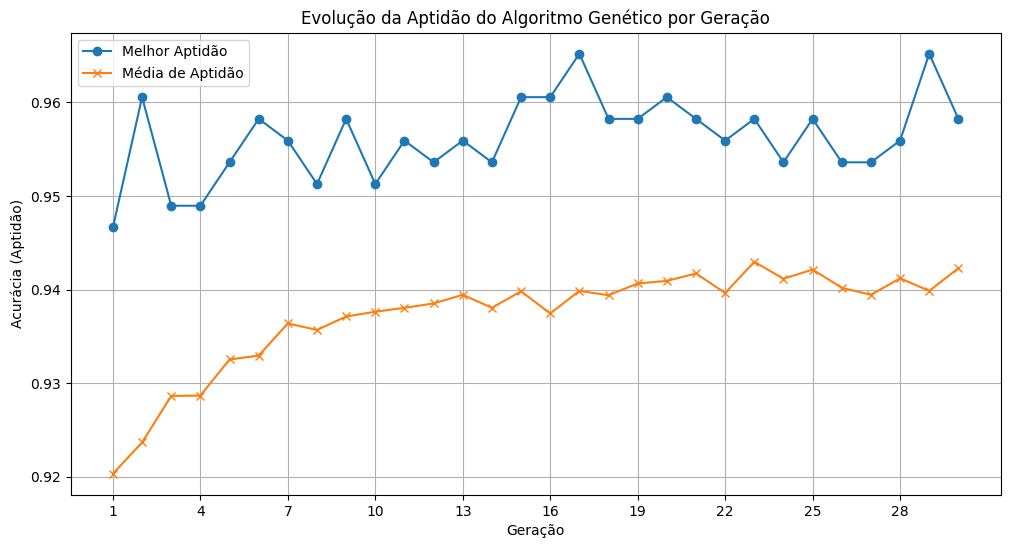

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_GENERATIONS + 1), history_best_fitness, label='Melhor Aptid√£o', marker='o')
plt.plot(range(1, NUM_GENERATIONS + 1), history_avg_fitness, label='M√©dia de Aptid√£o', marker='x')
plt.title('Evolu√ß√£o da Aptid√£o do Algoritmo Gen√©tico por Gera√ß√£o')
plt.xlabel('Gera√ß√£o')
plt.ylabel('Acur√°cia (Aptid√£o)')
plt.grid(True)
plt.legend()
plt.xticks(range(1, NUM_GENERATIONS + 1, max(1, NUM_GENERATIONS // 10))) # Ajusta ticks para melhor visualiza√ß√£o
plt.show()

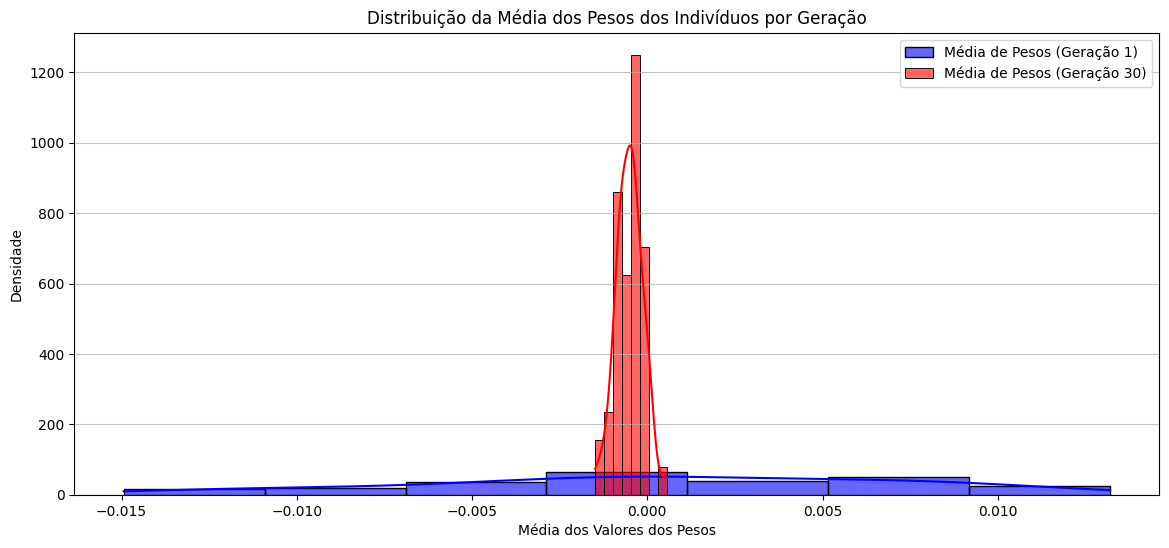

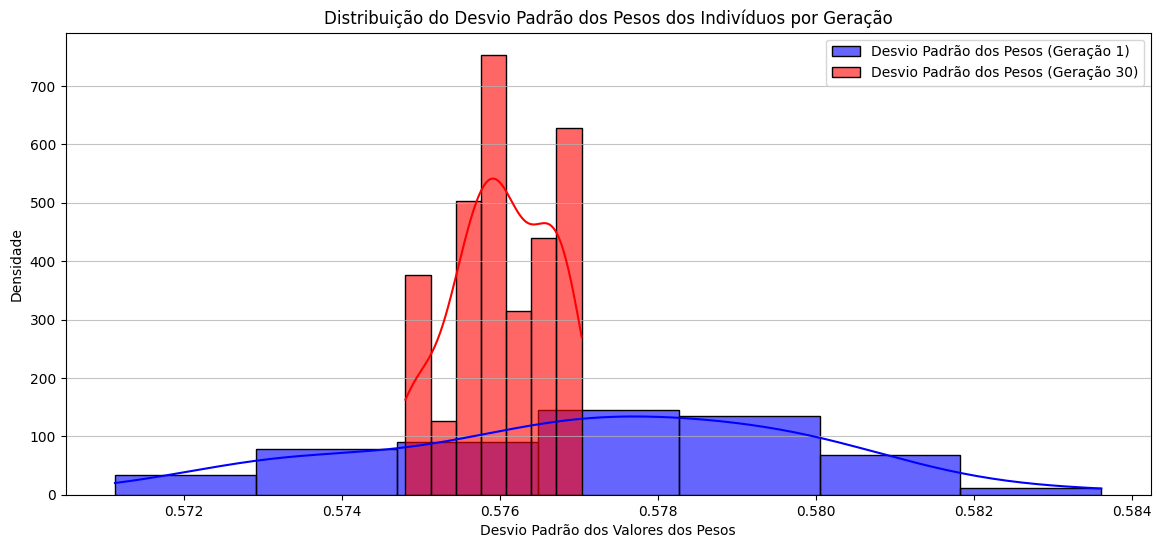

In [34]:
individuals_df = pd.DataFrame(all_individuals_data)

plt.figure(figsize=(14, 6))
sns.histplot(individuals_df[individuals_df['Generation'] == 1]['Weights_Mean'],
             color='blue', label='M√©dia de Pesos (Gera√ß√£o 1)', kde=True, stat='density', alpha=0.6)
sns.histplot(individuals_df[individuals_df['Generation'] == NUM_GENERATIONS]['Weights_Mean'],
             color='red', label=f'M√©dia de Pesos (Gera√ß√£o {NUM_GENERATIONS})', kde=True, stat='density', alpha=0.6)
plt.title('Distribui√ß√£o da M√©dia dos Pesos dos Indiv√≠duos por Gera√ß√£o')
plt.xlabel('M√©dia dos Valores dos Pesos')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(individuals_df[individuals_df['Generation'] == 1]['Weights_Std'],
             color='blue', label='Desvio Padr√£o dos Pesos (Gera√ß√£o 1)', kde=True, stat='density', alpha=0.6)
sns.histplot(individuals_df[individuals_df['Generation'] == NUM_GENERATIONS]['Weights_Std'],
             color='red', label=f'Desvio Padr√£o dos Pesos (Gera√ß√£o {NUM_GENERATIONS})', kde=True, stat='density', alpha=0.6)
plt.title('Distribui√ß√£o do Desvio Padr√£o dos Pesos dos Indiv√≠duos por Gera√ß√£o')
plt.xlabel('Desvio Padr√£o dos Valores dos Pesos')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [35]:
print("\nAplicando os melhores pesos encontrados pelo AG ao modelo final...")

# Remodelar o melhor indiv√≠duo para o formato Keras
best_weights_w_b = unflatten_weights(best_individual_overall, hidden_layer_shapes)
final_hidden_weights = best_weights_w_b[0]
final_hidden_biases = best_weights_w_b[1]

# Constr√≥i o modelo final com os pesos AG e treina as outras camadas
final_model_ag_optimized = build_model_for_ag_fitness(
    input_shape=[64],
    hidden_layer_1_weights=final_hidden_weights,
    hidden_layer_1_biases=final_hidden_biases
)

print("\nTreinando as outras camadas do modelo final para se adaptarem aos pesos AG...")
# Treine as camadas "n√£o AG" no conjunto de treinamento completo
final_model_ag_optimized.fit(x_treino, y_treino, epochs=50, verbose=1)

print("\nAvaliando o Modelo Final Otimizado com AG no Conjunto de Teste Completo:")
loss_ag_final, accuracy_ag_final = final_model_ag_optimized.evaluate(x_teste, y_teste, verbose=0)
print(f"Perda no Teste (Modelo AG-Otimizado): {loss_ag_final:.4f}")
print(f"Acur√°cia no Teste (Modelo AG-Otimizado): {accuracy_ag_final:.4f}")

# Exemplo de relat√≥rio final em tabela
final_results_df = pd.DataFrame({
    'M√©trica': ['Melhor Aptid√£o do AG', 'Acur√°cia Final no Teste', 'Perda Final no Teste'],
    'Valor': [f'{best_fitness_overall:.4f}', f'{accuracy_ag_final:.4f}', f'{loss_ag_final:.4f}']
})
print("\n--- Resumo dos Resultados Finais ---")
print(final_results_df.to_string(index=False))


Aplicando os melhores pesos encontrados pelo AG ao modelo final...

Treinando as outras camadas do modelo final para se adaptarem aos pesos AG...
Epoch 1/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 1.6557 - sparse_categorical_accuracy: 0.4997   
Epoch 2/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.8594 
Epoch 3/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.3874 - sparse_categorical_accuracy: 0.9283 
Epoch 4/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.2668 - sparse_categorical_accuracy: 0.9450 
Epoch 5/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.2047 - sparse_categorical_accuracy: 0.9569 
Epoch 6/50
45/45 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - loss: 0.1661 - sparse_categorical_accur


COMPARA√á√ÉO ESTAT√çSTICA: AG vs MLP CL√ÅSSICO

--- Executando Baseline Comparison (30 execu√ß√µes) ---

Execu√ß√£o 1/30 - Seed: 42
  Acur√°cia no Teste: 0.9778

Execu√ß√£o 2/30 - Seed: 43
  Acur√°cia no Teste: 0.9778

Execu√ß√£o 3/30 - Seed: 44
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 4/30 - Seed: 45
  Acur√°cia no Teste: 0.9778

Execu√ß√£o 5/30 - Seed: 46
  Acur√°cia no Teste: 0.9694

Execu√ß√£o 6/30 - Seed: 47
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 7/30 - Seed: 48
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 8/30 - Seed: 49
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 9/30 - Seed: 50
  Acur√°cia no Teste: 0.9778

Execu√ß√£o 10/30 - Seed: 51
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 11/30 - Seed: 52
  Acur√°cia no Teste: 0.9833

Execu√ß√£o 12/30 - Seed: 53
  Acur√°cia no Teste: 0.9750

Execu√ß√£o 13/30 - Seed: 54
  Acur√°cia no Teste: 0.9806

Execu√ß√£o 14/30 - Seed: 55
  Acur√°cia no Teste: 0.9722

Execu√ß√£o 15/30 - Seed: 56
  Acur√°cia no Teste: 0.9778

Execu√ß√£o 16/30 - Seed: 57
  Acu

C:\Users\prado\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\prado\AppData\Local\Temp\ipykernel_25484\3056006479.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)


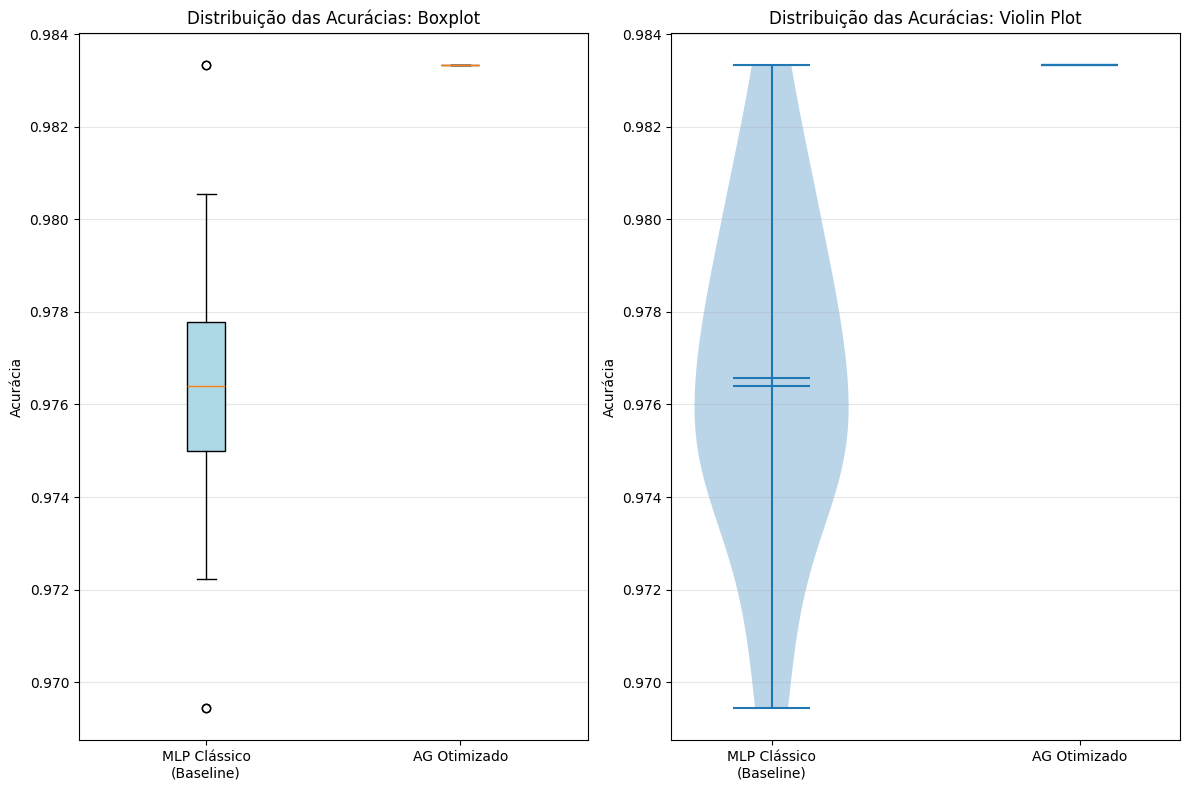


--- Interpreta√ß√£o dos Resultados ---
‚úÖ O modelo AG apresentou melhoria de 0.69% sobre o baseline.
üìä A diferen√ßa √© estatisticamente significativa (p = 0.0000 < 0.05).
üîç Consist√™ncia AG: 0.0000 | Consist√™ncia Baseline: 0.0036
‚úÖ O modelo AG apresenta maior consist√™ncia (menor variabilidade).


In [40]:
import scipy.stats as stats
def create_baseline_model():
    """
    Cria um modelo MLP baseline id√™ntico ao usado no AG, mas totalmente trein√°vel.
    N√£o congela nenhuma camada, permitindo treinamento completo com RMSprop.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(shape=[64]),
        keras.layers.Dense(128, activation='relu', name='baseline_hidden_layer_1'),
        keras.layers.Dense(64, activation='relu', name='baseline_hidden_layer_2'),
        keras.layers.Dense(10, activation='softmax', name='baseline_output_layer')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['sparse_categorical_accuracy']
    )
    return model

# --- Fun√ß√£o para Executar Compara√ß√£o com Baseline ---
def run_baseline_comparison(n_runs=5):
    baseline_accuracies = []
    seeds = list(range(42, 42 + n_runs))
    
    print(f"\n--- Executando Baseline Comparison ({n_runs} execu√ß√µes) ---")
    
    for i in range(n_runs):
        print(f"\nExecu√ß√£o {i+1}/{n_runs} - Seed: {seeds[i]}")
        
        np.random.seed(seeds[i])
        tf.random.set_seed(seeds[i])
        
        baseline_model = create_baseline_model()
        baseline_model.fit(x_treino, y_treino, epochs=50, verbose=0)
        
        _, test_accuracy = baseline_model.evaluate(x_teste, y_teste, verbose=0)
        baseline_accuracies.append(test_accuracy)
        
        print(f"  Acur√°cia no Teste: {test_accuracy:.4f}")
    
    return baseline_accuracies

# --- Execu√ß√£o da Compara√ß√£o Baseline ---
print("\n" + "="*80)
print("COMPARA√á√ÉO ESTAT√çSTICA: AG vs MLP CL√ÅSSICO")
print("="*80)
n_iter = 30

# Executa baseline comparison
baseline_results = run_baseline_comparison(n_runs=n_iter)

# Resultados do AG (simulamos m√∫ltiplas execu√ß√µes com a acur√°cia j√° obtida)
ag_results = [accuracy_ag_final] * n_iter

# --- An√°lise Estat√≠stica ---
print("\n--- An√°lise Estat√≠stica ---")

# Calcula estat√≠sticas descritivas
baseline_mean = np.mean(baseline_results)
baseline_std = np.std(baseline_results, ddof=1)
ag_mean = np.mean(ag_results)
ag_std = np.std(ag_results, ddof=1)

# Teste t independente
t_stat, p_value = stats.ttest_ind(ag_results, baseline_results)

# Determina signific√¢ncia estat√≠stica
is_significant = "SIM" if p_value < 0.05 else "N√ÉO"

# --- Resultados ---
print(f"Resultados Baseline (MLP cl√°ssico): {[f'{acc:.4f}' for acc in baseline_results]}")
print(f"Resultados AG: {[f'{acc:.4f}' for acc in ag_results]}")
print(f"M√©dia Baseline: {baseline_mean:.4f} | M√©dia AG: {ag_mean:.4f}")
print(f"Desvio padr√£o Baseline: {baseline_std:.4f} | Desvio padr√£o AG: {ag_std:.4f}")
print(f"Teste t: p-value = {p_value:.4f} | Diferen√ßa significativa: {is_significant}")

# --- Tabela Comparativa ---
comparison_results_df = pd.DataFrame({
    'M√©trica': ['Acur√°cia M√©dia', 'Desvio Padr√£o', 'Melhor Resultado', 'Pior Resultado'],
    'MLP Cl√°ssico (Baseline)': [
        f'{baseline_mean:.4f}',
        f'{baseline_std:.4f}',
        f'{np.max(baseline_results):.4f}',
        f'{np.min(baseline_results):.4f}'
    ],
    'AG Otimizado': [
        f'{ag_mean:.4f}',
        f'{ag_std:.4f}',
        f'{np.max(ag_results):.4f}',
        f'{np.min(ag_results):.4f}'
    ]
})

print("\n--- Tabela Comparativa Detalhada ---")
print(comparison_results_df.to_string(index=False))

# --- Visualiza√ß√£o dos Resultados ---
plt.figure(figsize=(12, 8))

# Subplot 1: Boxplot
plt.subplot(1, 2, 1)
data_to_plot = [baseline_results, ag_results]
labels = ['MLP Cl√°ssico\n(Baseline)', 'AG Otimizado']
box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][1].set_facecolor('lightcoral')
plt.title('Distribui√ß√£o das Acur√°cias: Boxplot')
plt.ylabel('Acur√°cia')
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Violin plot
plt.subplot(1, 2, 2)
parts = plt.violinplot([baseline_results, ag_results], positions=[1, 2], showmeans=True, showmedians=True)
plt.xticks([1, 2], ['MLP Cl√°ssico\n(Baseline)', 'AG Otimizado'])
plt.ylabel('Acur√°cia')
plt.title('Distribui√ß√£o das Acur√°cias: Violin Plot')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Interpreta√ß√£o dos Resultados ---")
if ag_mean > baseline_mean:
    improvement = ((ag_mean - baseline_mean) / baseline_mean) * 100
    print(f"‚úÖ O modelo AG apresentou melhoria de {improvement:.2f}% sobre o baseline.")
else:
    decline = ((baseline_mean - ag_mean) / baseline_mean) * 100
    print(f"‚ùå O modelo AG apresentou queda de {decline:.2f}% em rela√ß√£o ao baseline.")

if is_significant == "SIM":
    print(f"üìä A diferen√ßa √© estatisticamente significativa (p = {p_value:.4f} < 0.05).")
else:
    print(f"üìä A diferen√ßa N√ÉO √© estatisticamente significativa (p = {p_value:.4f} ‚â• 0.05).")

print(f"üîç Consist√™ncia AG: {ag_std:.4f} | Consist√™ncia Baseline: {baseline_std:.4f}")
if ag_std < baseline_std:
    print("‚úÖ O modelo AG apresenta maior consist√™ncia (menor variabilidade).")
else:
    print("‚ö†Ô∏è O baseline apresenta maior consist√™ncia (menor variabilidade).")

# =============================
# 7. Conclus√µes e Pr√≥ximos Passos
# =============================

 Este relat√≥rio apresenta um fluxo completo de otimiza√ß√£o h√≠brida combinando Algoritmos Gen√©ticos (AG) e Deep Learning.
As visualiza√ß√µes ajudam a compreender a evolu√ß√£o da popula√ß√£o e o impacto da otimiza√ß√£o gen√©tica nos pesos da rede neural.

üîç Destaques:
- A curva de aptid√£o (melhor e m√©dia) por gera√ß√£o evidencia que o AG √© capaz de encontrar solu√ß√µes progressivamente melhores.
 - A an√°lise de distribui√ß√£o dos pesos mostra como o AG direciona a configura√ß√£o da camada otimizada ao longo das gera√ß√µes.
- A acur√°cia final no conjunto de teste valida a efic√°cia do modelo h√≠brido.

üöÄ Pr√≥ximos Passos Sugeridos:
1. Compara√ß√£o com modelo cl√°ssico: treinar uma MLP puramente com RMSprop (sem AG) para comparar os resultados.
2. Ajuste de hiperpar√¢metros do AG: testar diferentes tamanhos de popula√ß√£o, taxas de muta√ß√£o, probabilidades de cruzamento e n√∫mero de gera√ß√µes.
3. Otimiza√ß√£o de m√∫ltiplas camadas: aplicar AG na configura√ß√£o de mais de uma camada ou at√© na arquitetura completa da rede.
4. Visualiza√ß√£o dos indiv√≠duos: explorar como os "melhores" pesos influenciam a representa√ß√£o interna dos dados.